[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# Convolution for Frequency Estimation

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 29/04/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0085DeepLearning1DConvFreqEst.ipynb)

In [2]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.datasets import fetch_california_housing

# Deep Learning
import torch
import torch.nn            as nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
from torchmetrics.regression import R2Score
import torchinfo

# Miscellaneous
import copy
import math
import os
from platform import python_version
import random
import time

# Typing
from typing import Callable, Dict, Generator, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import HTML, Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [3]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

# Improve performance by benchmarking
torch.backends.cudnn.benchmark = True

# Reproducibility
# torch.manual_seed(seedNum)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark     = False


In [4]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2

D_CLASSES_CIFAR_10  = {0: 'Airplane', 1: 'Automobile', 2: 'Bird', 3: 'Cat', 4: 'Deer', 5: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'}
L_CLASSES_CIFAR_10  = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
T_IMG_SIZE_CIFAR_10 = (32, 32, 3)

DATA_FOLDER_PATH    = 'Data'
TENSOR_BOARD_BASE   = 'TB'


In [5]:
# Download Auxiliary Modules for Google Colab
if runInGoogleColab:
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataManipulation.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataVisualization.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DeepLearningPyTorch.py

In [6]:
# Courses Packages
import sys
sys.path.append('/home/vlad/utils')
from DataVisualization import PlotRegressionResults
from DeepLearningPyTorch import NNMode, TrainModel


2024-06-03 04:39:05.743787: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# General Auxiliary Functions

def GenHarmonicData( numSignals: int, numSamples: int, samplingFreq: float, maxFreq: float, σ: float ) -> Tuple[torch.Tensor, torch.Tensor]:

    π = np.pi #<! Constant Pi

    vT   = torch.linspace(0, numSamples - 1, numSamples) / samplingFreq #<! Time samples
    vF   = maxFreq * torch.rand(numSignals)                             #<! Frequency per signal
    vPhi = 2 * π * torch.rand(numSignals)                               #<! Phase per signal
    
    # x_i(t) = sin(2π f_i t + φ_i) + n_i(t)
    mX = torch.sin(2 * π * vF[:, None] @ vT[None, :] + vPhi[:, None])       ## @ is matrix multiplication in PyTorch
    mX = mX + σ * torch.randn(mX.shape) #<! Add noise

    return mX, vF


## Frequency Estimation with 1D Convolution Model in PyTorch

This notebook **estimates the frequency** of a given set of samples of an _Harmonic Signal_.

The notebook presents:

 * Use of convolution layers in PyTorch.
 * Use of pool layers in PyTorch.
 * Use of adaptive pool layer in PyTorch.  
   The motivation is to set a constant output size regardless of input.
 * Use the model for inference on the test data.

</br>

 * <font color='brown'>(**#**)</font> While the layers are called _Convolution Layer_ they actually implement correlation.  
   Since the weights are learned, in practice it makes no difference as _Correlation_ is convolution with the a flipped kernel.



* <font color='red'>(**?**)</font> What kind of a problem it frequency estimation? - regression!

In [8]:
# Parameters

# Data
numSignalsTrain = 15_000
numSignalsVal   = 5_000
numSignalsTest  = 5_000

numSamples = 500 #<! Samples in Signal

maxFreq      = 10.0  #<! [Hz]
samplingFreq = 100.0 #<! [Hz]

σ      = 0.1 #<! Noise Std

# Model
dropP = 0.1 #<! Dropout Layer

# Training
batchSize   = 256
numWork     = 2 #<! Number of workers
nEpochs     = 20

# Visualization
numSigPlot = 5


## Generate / Load Data

This section generates the data from the following model:

$$\boldsymbol{x}_{i} \left( t \right) = \sin \left( 2 \pi {f}_{i} t + \phi_{i} \right) + \boldsymbol{n}_{i} \left( t \right) $$

 * $\boldsymbol{x}_{i}$ - Set of input samples (`numSamples`) of the $i$ -th _Harmonic Signal_.
 * ${f}_{i}$ - The signal frequency in the range `[0, maxFreq]`.
 * $t$ - Time sample.
 * $\phi_{i}$ - The signal phase in the range `[0, 2π]`.
 * $\boldsymbol{n}_{i}$ - Set of noise samples (`numSamples`) of the $i$ -th _Harmonic Signal_.  
   The noise standard deviation is set to `σ`.

The model input data is in the  format: ${N}_{b} \times {C} \times N$:

 * ${N}_{b}$ - Number of signals in the batch (`batchSize`).
 * $C$ - Number of channels (The signal is a single channel).

</br>

* <font color='brown'>(**#**)</font> Since it is a generated data set, data can be generated at will.
* <font color='brown'>(**#**)</font> The signal 1D with a single channel. EEG signals, Stereo Audio signal, ECG signals are examples for multi channel 1D signals.  
  The concept of 1D in this context is the index which the data is generated along.

In [9]:
# Generate Data

mXTrain, vYTrain    = GenHarmonicData(numSignalsTrain, numSamples, samplingFreq, maxFreq, σ) #<! Train Data
mXVal, vYVal        = GenHarmonicData(numSignalsVal, numSamples, samplingFreq, maxFreq, σ)   #<! Validation Data
mXTest, vYTest      = GenHarmonicData(numSignalsTest, numSamples, samplingFreq, maxFreq, σ)  #<! Test Data

vT = np.linspace(0, numSamples - 1, numSamples) / samplingFreq #<! For plotting

mX = torch.concatenate((mXTrain, mXVal), axis = 0)
vY = torch.concatenate((vYTrain, vYVal), axis = 0)

print(f'The features data shape: {mX.shape}')
print(f'The labels data shape: {vY.shape}')


The features data shape: torch.Size([20000, 500])
The labels data shape: torch.Size([20000])


* <font color='red'>(**?**)</font> What is the content of `vY` above? Explain its shape.

### Plot Data

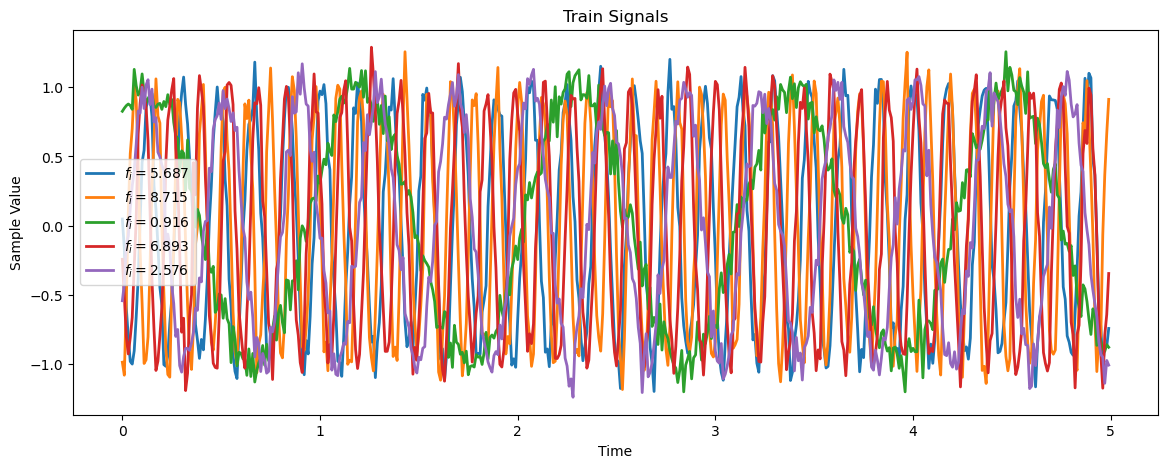

In [10]:
# Plot the Data

hF, hA = plt.subplots(figsize = (14, 5))
for _ in range(numSigPlot):
    idxSig = np.random.randint(numSignalsTrain)
    vX  = mXTrain[idxSig,:]
    hA.plot(vT, vX, lw = 2, label = f'$f_i = {(vYTrain[idxSig].item()):.3f}$')

hA.set_title('Train Signals')
hA.set_xlabel('Time')
hA.set_ylabel('Sample Value')
hA.legend()
plt.show()

In [16]:
print(f"mXTrain.shape = {mXTrain.shape}")
print(f"vXType = {type(mXTrain)}")

print(f'converted view shape {mXTrain.view(numSignalsTrain, 1, -1).shape}')

mXTrain.shape = torch.Size([15000, 500])
vXType = <class 'torch.Tensor'>
converted view shape torch.Size([15000, 1, 500])


 help view:

 ```
 |  view(...)
 |      view(*shape) -> Tensor
 |      
 |      Returns a new tensor with the same data as the :attr:`self` tensor but of a
 |      different :attr:`shape`.
 |      
 |      The returned tensor shares the same data and must have the same number
 |      of elements, but may have a different size. For a tensor to be viewed, the new
 |      view size must be compatible with its original size and stride, i.e., each new
 |      view dimension must either be a subspace of an original dimension, or only span
 |      across original dimensions :math:`d, d+1, \dots, d+k` that satisfy the following
 |      contiguity-like condition that :math:`\forall i = d, \dots, d+k-1`,
 |      
 |      .. math::
 |      
 |        \text{stride}[i] = \text{stride}[i+1] \times \text{size}[i+1]
 |      
 |      Otherwise, it will not be possible to view :attr:`self` tensor as :attr:`shape`
 |      without copying it (e.g., via :meth:`contiguous`). When it is unclear whether a
 |      :meth:`view` can be performed, it is advisable to use :meth:`reshape`, which
 |      returns a view if the shapes are compatible, and copies (equivalent to calling
 |      :meth:`contiguous`) otherwise.
 |      
 |      Args:
 |          shape (torch.Size or int...): the desired size
 |      
 |      Example::
 |      
 |          >>> x = torch.randn(4, 4)
 |          >>> x.size()
 |          torch.Size([4, 4])
 |          >>> y = x.view(16)
 |          >>> y.size()
 |          torch.Size([16])
 |          >>> z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
 |          >>> z.size()
 |          torch.Size([2, 8])

 ```

### Input Data

There are several ways to convert the data into the shape expected by the model convention:

```python
# Assume: mX.shape = (N, L)
mX = mX.view(N, 1, L) #<! Option I
mX = mX.unsqueeze(1)  #<! Option II
mX = mX[:, None, :]   #<! Option III
#Output: mX.shape = (N, 1, L)
```

In [16]:
# Data Sets

dsTrain = torch.utils.data.TensorDataset(mXTrain.view(numSignalsTrain, 1, -1), vYTrain) #<! -1 -> Infer
dsVal   = torch.utils.data.TensorDataset(mXVal.view(numSignalsVal, 1, -1), vYVal)
dsTest  = torch.utils.data.TensorDataset(mXTest.view(numSignalsTest, 1, -1), vYTest)

* <font color='red'>(**?**)</font> Does the data require standardization? Why?

-- no need the data is generated with the same scale in 0-1 range.

In [17]:
# Data Loaders

# Data is small, no real need for workers
dlTrain  = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize, num_workers = numWork, persistent_workers = True)
dlTest   = torch.utils.data.DataLoader(dsTest, shuffle = False, batch_size = 2 * batchSize, num_workers = numWork, persistent_workers = True)

In [18]:
# Iterate on the Loader
# The first batch.
tX, vY = next(iter(dlTrain)) #<! PyTorch Tensors

print(f'The batch features dimensions: {tX.shape}')
print(f'The batch labels dimensions: {vY.shape}')

The batch features dimensions: torch.Size([256, 1, 500])
The batch labels dimensions: torch.Size([256])


## Define the Model

The model is defined as a sequential model.


In [19]:
# Model
# Defining a sequential model.

numFeatures = mX.shape[1]

def GetModel( ) -> nn.Module:
    oModel = nn.Sequential(
        nn.Identity(),
        
        nn.Conv1d(in_channels = 1,   out_channels = 32,  kernel_size = 11), nn.MaxPool1d(kernel_size = 2), nn.ReLU(),
        nn.Conv1d(in_channels = 32,  out_channels = 64,  kernel_size = 11), nn.MaxPool1d(kernel_size = 2), nn.ReLU(),
        nn.Conv1d(in_channels = 64,  out_channels = 128, kernel_size = 11), nn.MaxPool1d(kernel_size = 2), nn.ReLU(),
        nn.Conv1d(in_channels = 128, out_channels = 256, kernel_size = 11), nn.MaxPool1d(kernel_size = 2), nn.ReLU(),
                
        nn.AdaptiveAvgPool1d(output_size = 1),
        nn.Flatten          (),
        nn.Linear           (in_features = 256, out_features = 1),
        nn.Flatten          (start_dim = 0),
        )
    
    return oModel



```
layer1: 
==========

cin =1  cout = 32   size=11 

32*11 + 32 = 384


adaptive avg pool1d:
====================

input was (256 256 21)
then that block just average that to 1 dim : (256 256 1)
```

* <font color='brown'>(**#**)</font> The [`torch.nn.AdaptiveAvgPool1d`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool1d.html) allows the same output shape regard less of the  input.
* <font color='red'>(**?**)</font> What is the role of the [`torch.nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) layers?

In [20]:
# Model Summary

oModel = GetModel()
torchinfo.summary(oModel, tX.shape, device = 'cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [256]                     --
├─Identity: 1-1                          [256, 1, 500]             --
├─Conv1d: 1-2                            [256, 32, 490]            384
├─MaxPool1d: 1-3                         [256, 32, 245]            --
├─ReLU: 1-4                              [256, 32, 245]            --
├─Conv1d: 1-5                            [256, 64, 235]            22,592
├─MaxPool1d: 1-6                         [256, 64, 117]            --
├─ReLU: 1-7                              [256, 64, 117]            --
├─Conv1d: 1-8                            [256, 128, 107]           90,240
├─MaxPool1d: 1-9                         [256, 128, 53]            --
├─ReLU: 1-10                             [256, 128, 53]            --
├─Conv1d: 1-11                           [256, 256, 43]            360,704
├─MaxPool1d: 1-12                        [256, 256, 21]            --
├

* <font color='brown'>(**#**)</font> Pay attention the dropout parameter of PyTorch is about the probability to zero out the value.

In [21]:
# Run Model
# Apply a test run.

mXX = torch.randn(batchSize, numSamples)
mXX = mXX.view(batchSize, 1, numSamples)
with torch.inference_mode():
    vYHat = oModel(mXX)

print(f'The input dimensions: {mXX.shape}')
print(f'The output dimensions: {vYHat.shape}')

The input dimensions: torch.Size([256, 1, 500])
The output dimensions: torch.Size([256])


## Training Loop

Use the training and validation samples.  
The objective will be defined as the Mean Squared Error and the score as ${R}^{2}$.


* <font color='red'>(**?**)</font> Will the best model loss wise will be the model with the best score? Explain specifically and generally (For other loss and scores).

-- not necessarily, the loss is the difference between the predicted value and the true value, while the score is the correlation between the predicted value and the true value.

## Train the Model

In [22]:
# Check GPU Availability

runDevice   = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #<! The 1st CUDA device
oModel      = oModel.to(runDevice) #<! Transfer model to device

In [23]:
# Set the Loss & Score

hL = nn.MSELoss()
hS = R2Score(num_outputs = 1)
hS = hS.to(runDevice)

In [24]:
# Define Optimizer

oOpt = torch.optim.AdamW(oModel.parameters(), lr = 1e-4, betas = (0.9, 0.99), weight_decay = 1e-5) #<! Define optimizer

In [25]:
# Train the Model

oRunModel, lTrainLoss, lTrainScore, lValLoss, lValScore, _ = TrainModel(oModel, dlTrain, dlTest, oOpt, nEpochs, hL, hS)


Epoch    1 / 20 | Train Loss: 11.911 | Val Loss:  1.082 | Train Score: -0.425 | Val Score:  0.870 | Epoch Time: 18.70 | <-- Checkpoint! |
Epoch    2 / 20 | Train Loss:  0.358 | Val Loss:  0.107 | Train Score:  0.957 | Val Score:  0.987 | Epoch Time:  1.82 | <-- Checkpoint! |
Epoch    3 / 20 | Train Loss:  0.054 | Val Loss:  0.021 | Train Score:  0.994 | Val Score:  0.998 | Epoch Time:  1.83 | <-- Checkpoint! |
Epoch    4 / 20 | Train Loss:  0.013 | Val Loss:  0.008 | Train Score:  0.998 | Val Score:  0.999 | Epoch Time:  1.81 | <-- Checkpoint! |
Epoch    5 / 20 | Train Loss:  0.007 | Val Loss:  0.007 | Train Score:  0.999 | Val Score:  0.999 | Epoch Time:  1.80 | <-- Checkpoint! |
Epoch    6 / 20 | Train Loss:  0.005 | Val Loss:  0.005 | Train Score:  0.999 | Val Score:  0.999 | Epoch Time:  1.81 | <-- Checkpoint! |
Epoch    7 / 20 | Train Loss:  0.004 | Val Loss:  0.005 | Train Score:  0.999 | Val Score:  0.999 | Epoch Time:  1.85 | <-- Checkpoint! |
Epoch    8 / 20 | Train Loss:  0.0

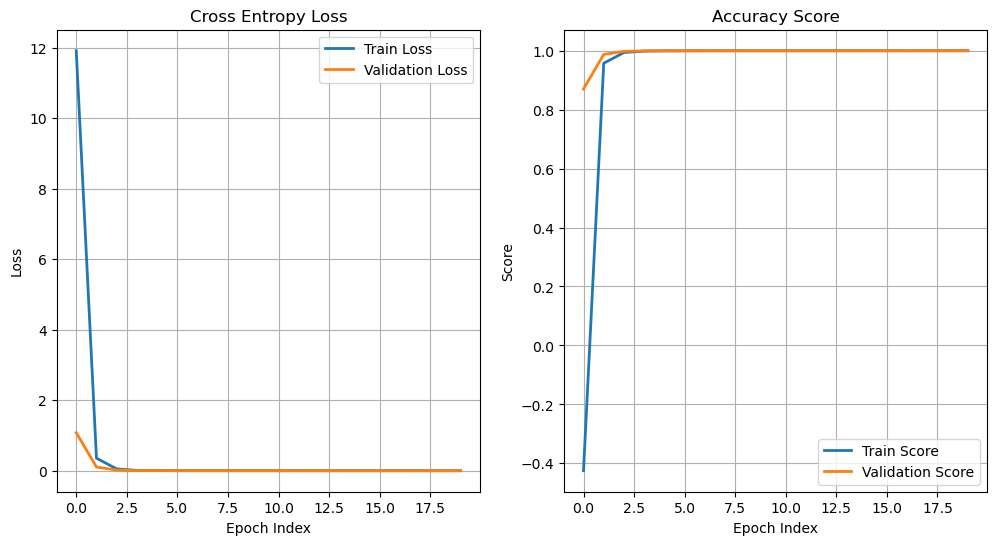

In [26]:
# Plot Results
hF, vHa = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
vHa = vHa.flat

hA = vHa[0]
hA.plot(lTrainLoss, lw = 2, label = 'Train Loss')
hA.plot(lValLoss, lw = 2, label = 'Validation Loss')
hA.grid()
hA.set_title('Cross Entropy Loss')
hA.set_xlabel('Epoch Index')
hA.set_ylabel('Loss')
hA.legend();


hA = vHa[1]
hA.plot(lTrainScore, lw = 2, label = 'Train Score')
hA.plot(lValScore, lw = 2, label = 'Validation Score')
hA.grid()
hA.set_title('Accuracy Score')
hA.set_xlabel('Epoch Index')
hA.set_ylabel('Score')
hA.legend();


## Test Data Analysis 

This section runs the model on the test data and analyze results.

### Test Data Results

In [27]:
# Run on Test Data
lYY     = []
lYYHat  = []
with torch.inference_mode():
    for tXX, vYY in dlTest:
        tXX = tXX.to(runDevice)
        lYY.append(vYY)
        lYYHat.append(oModel(tXX))

vYY    = torch.cat(lYY, dim = 0).cpu().numpy()
vYYHat = torch.cat(lYYHat, dim = 0).cpu().numpy()

* <font color='brown'>(**#**)</font> One could run the above using `mXTest`.  
  The motivation is to show the general way which can handle large data set.

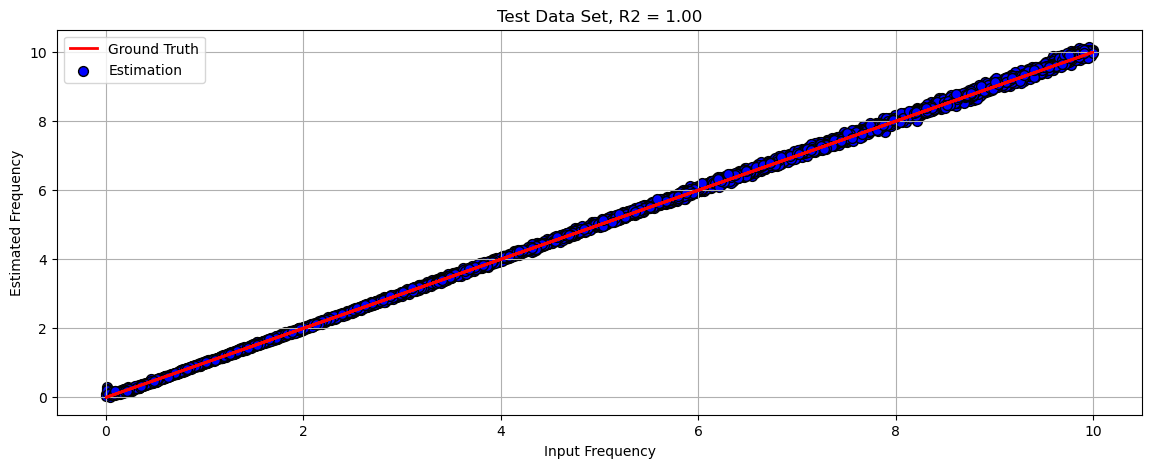

In [28]:
# Plot Regression Result

# Plot the Data

scoreR2 = hS(torch.tensor(vYY), torch.tensor(vYYHat))

hF, hA = plt.subplots(figsize = (14, 5))
hA = PlotRegressionResults(vYY, vYYHat, hA = hA)
hA.set_title(f'Test Data Set, R2 = {scoreR2:0.2f}')
hA.grid()
hA.set_xlabel('Input Frequency')
hA.set_ylabel('Estimated Frequency')

plt.show()


* <font color='red'>(**?**)</font> Can you find where the model struggles?
* <font color='red'>(**?**)</font> Can it handle shorter signals? For examples 200 samples. How?
* <font color='red'>(**?**)</font> How will it generalize to cases with frequency above `maxFreq`?

### Extended Test Set

This section shows the performance of the model on data with frequencies spanned on the range `[0, 2 * maxFreq]`.

In [29]:
# Generate Data

mXTest, vYTest = GenHarmonicData(numSignalsTest, numSamples, samplingFreq, 2 * maxFreq, σ)  #<! Test Data

In [30]:
# Run on Test Data

with torch.inference_mode():
    vYTestHat = oModel(mXTest.view(numSignalsTest, 1, -1).to(runDevice))

vYTestHat = vYTestHat.cpu()

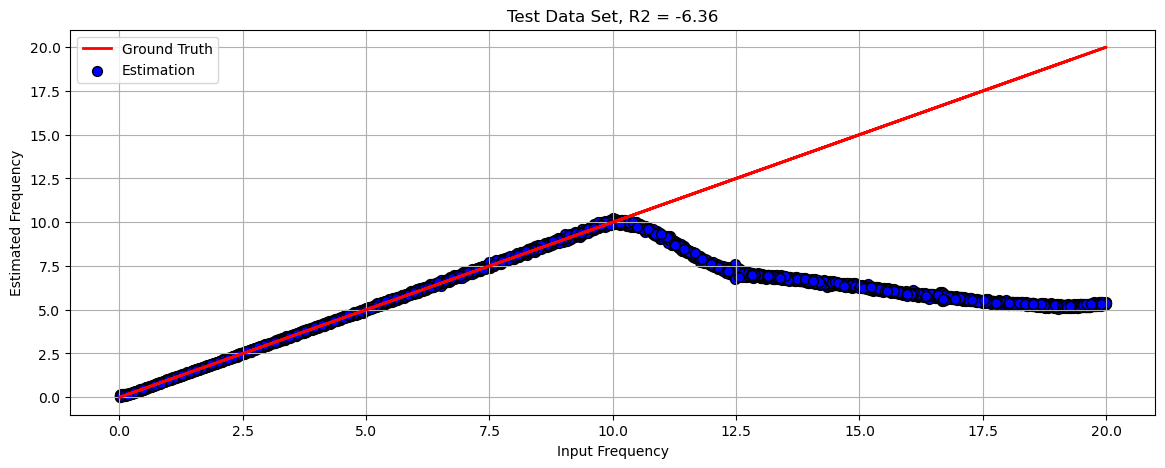

In [31]:
# Plot Regression Result

# Plot the Data

scoreR2 = hS(vYTest, vYTestHat)

hF, hA = plt.subplots(figsize = (14, 5))
hA = PlotRegressionResults(vYTest.cpu().numpy(), vYTestHat.cpu().numpy(), hA = hA)
hA.set_title(f'Test Data Set, R2 = {scoreR2:0.2f}')
hA.grid()
hA.set_xlabel('Input Frequency')
hA.set_ylabel('Estimated Frequency')

plt.show()


* <font color='red'>(**?**)</font> Why does the model perform poorly?

the network didnt learned the frequency; אין הכללה

* <font color='brown'>(**#**)</font> DL models do extrapolate and able to generalize (Think model which plays Chess).  
  Yet in order to generalize, the model loss and architecture has to built accordingly.  
  For most common cases, one must validate the train set matches the production data.